# 알약 이미지 데이터셋 EDA (Exploratory Data Analysis) - v1

## Imports & 한글 폰트 설정 (환경 초기화)

이 섹션은 분석에 필요한 라이브러리를 불러오고, matplotlib에서 한글이 깨지지 않도록 폰트를 설정합니다. 
신입 팁: 라이브러리는 '도구 상자'처럼 생각하세요. 각 라이브러리는 특정 작업(예: 데이터 처리, 그래프 그리기)을 돕습니다.

In [ ]:
# 1. 라이브러리 불러오기 (Imports)
# - json: JSON 파일을 읽고 쓰는 데 사용 (데이터가 JSON 형식으로 저장되어 있음).
# - pandas (pd): 데이터프레임(DataFrame)으로 데이터를 테이블처럼 다루는 라이브러리. 엑셀처럼 생각하세요.
# - cv2: OpenCV 라이브러리 (이미지 처리용, 하지만 이 스크립트에서는 아직 안 씀).
# - matplotlib.pyplot (plt): 그래프를 그리는 라이브러리. 시각화의 기본.
# - numpy (np): 숫자 배열을 효율적으로 다루는 라이브러리. 계산 속도가 빠름.
# - collections.Counter: 데이터의 빈도(카운트)를 세는 도구.
# - pathlib.Path: 파일 경로를 안전하게 다루는 클래스 (os.path보다 현대적).
# - os: 운영체제 관련 기능 (파일 존재 확인 등).
# - PIL (Pillow): 이미지 처리 라이브러리. 텍스트를 이미지에 오버레이(겹쳐 쓰기)할 때 사용.
# - seaborn (sns): matplotlib을 더 예쁘게 만드는 라이브러리 (히트맵 등에 유용).
import json
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from pathlib import Path
import os
from PIL import Image, ImageDraw, ImageFont  # 한글 텍스트 오버레이용
import seaborn as sns

# 2. 한글 폰트 설정 (matplotlib에서 한글이 깨지지 않게 함)
# - matplotlib.font_manager (fm): 폰트를 관리하는 모듈.
# - font_path: 한글 폰트 파일 경로 (NanumBarunGothic.ttf). 이 파일이 없으면 기본 폰트 사용.
# - addfont: 폰트를 matplotlib에 등록.
# - rc('font', family=...): 전체 그래프에 폰트를 적용.
# 한글이 깨지는 이유는 matplotlib의 기본 폰트가 영어 중심이기 때문. 이 설정으로 해결.
import matplotlib.font_manager as fm
font_path = "../NanumBarunGothic.ttf"  # 상대 경로: 상위 폴더의 폰트 파일.
if Path(font_path).exists():  # 파일이 존재하는지 확인 (Path.exists()로 안전하게).
    fm.fontManager.addfont(font_path)
    plt.rc('font', family='NanumBarunGothic')  # 그래프 전체에 한글 폰트 적용.
    print(f"한글 폰트 로드 성공: {font_path}")  # 성공 메시지 출력 (디버깅용).
else:
    print(f"경고: {font_path} 파일이 없음. 기본 폰트 사용. (그래프에 한글이 깨질 수 있음)")
    # 대안: 시스템 기본 한글 폰트 시도 (Windows: malgun.ttf, macOS: AppleGothic 등).
    try:
        plt.rc('font', family='DejaVu Sans')  # 영어 폰트 fallback.
    except:
        pass  # 실패해도 무시.

한글 폰트 로드 성공: ../NanumBarunGothic.ttf


## 데이터 로드 (JSON → DataFrame 변환)

이 섹션은 JSON 파일(알약 데이터)을 읽어 pandas DataFrame으로 변환합니다. 
DataFrame은 테이블 형식의 데이터로, 행/열로 쉽게 분석할 수 있습니다. 
JSON은 '키-값' 쌍으로 된 파일 형식 (예: {"name": "알약1"}). 이를 DataFrame으로 바꾸면 엑셀처럼 다룰 수 있어요.

In [ ]:
# 1. JSON 파일 경로 설정 및 로드
# - json_path: 처리된 JSON 파일 경로 (merge_annotations.py 스크립트로 생성된 파일).
# - Path.exists(): 파일이 실제로 존재하는지 확인. 없으면 에러 발생시켜 미리 알림.
json_path = '../data/processed/train_annotations_integrated.json'
if not Path(json_path).exists():
    raise FileNotFoundError(f"오류: JSON 파일이 없습니다: {json_path}. 먼저 merge_annotations.py를 실행하세요.")  # 에러 발생: 작업 순서 상기.

# 2. JSON 파일 읽기
# - open(..., encoding='utf-8'): UTF-8로 한글 깨짐 방지.
# - json.load(): JSON을 Python 딕셔너리로 변환.
with open(json_path, 'r', encoding='utf-8') as f:  # 'with' 문: 파일을 자동으로 닫음 (자원 관리).
    data = json.load(f)  # data: {'images': [...], 'annotations': [...], 'categories': [...]} 형식.

# 3. DataFrame으로 변환
# - pd.DataFrame(): 딕셔너리의 각 키를 별도 테이블로 만듦.
# - images_df: 이미지 메타데이터 (파일명, 크기 등).
# - anns_df: 어노테이션 (bbox 좌표, 클래스 ID 등).
# - categories_df: 클래스 정보 (ID, 이름 등).
images_df = pd.DataFrame(data['images'])  # 이미지 목록 테이블.
anns_df = pd.DataFrame(data['annotations'])  # 각 알약의 라벨/bbox 테이블.
categories_df = pd.DataFrame(data['categories'])  # 클래스 이름 테이블.

# 4. 기본 통계 출력 (데이터 규모 확인)
# - len(): 테이블의 행 수 (데이터 개수).
print(f"전체 이미지 수: {len(images_df)}")  # 이미지 개수.
print(f"어노테이션 수: {len(anns_df)}")  # bbox/라벨 개수 (이미지당 여러 개 가능).
print(f"클래스(알약 종류) 수: {len(categories_df)}")  # 고유 알약 클래스 개수.

# 출력으로 데이터가 제대로 로드되었는지 확인. 이미지와 어노테이션이 같아야 이상적임.

전체 이미지 수: 4526
어노테이션 수: 4526
클래스(알약 종류) 수: 73


## 기본 통계 - 클래스/코드 분포 & bbox 유효성

이 섹션은 클래스(알약 종류) 분포를 세고, bbox(경계 상자)가 유효한지 검사합니다. 
'분포'는 '얼마나 자주 나오는지' 의미. 이를 통해 불균형 데이터(몇몇 클래스가 많음)를 발견할 수 있어요.

In [ ]:
# 1. 클래스 분포 계산 (어떤 알약 종류가 얼마나 많은지)
# - Counter(anns_df['category_id']): category_id 열의 값을 세서 딕셔너리 반환 (e.g., {id: count}).
# - pd.Series(...).sort_values(ascending=False): 시리즈로 변환 후 내림차순 정렬.
class_dist = Counter(anns_df['category_id'])
print("클래스 분포 (상위부터):")
print(pd.Series(class_dist).sort_values(ascending=False))
print()  # 빈 줄 출력으로 가독성 높임.

# 2. 알약 코드 분포 (상위 10개만, dl_mapping_code 기준)
# - Counter(images_df['dl_mapping_code']): 이미지 테이블의 코드 열 카운트.
# - most_common(10): 상위 10개 반환.
code_dist = Counter(images_df['dl_mapping_code'])
print("알약 코드 분포 (상위 10개):")
print(code_dist.most_common(10))
print()

# 3. 더미 코드 확인 (특정 코드가 데이터에 있는지 검사, e.g., 테스트용 더미)
# - dummy_codes: 검사할 코드 리스트.
dummy_codes = ['K-010224']  # 예시: 더미 코드 목록.
for code in dummy_codes:
    count = code_dist.get(code, 0)  # .get(): 없으면 0 반환 (KeyError 방지).
    print(f"{code} 개수: {count}")
print()

# 4. bbox 유효성 검사 (bbox가 제대로 된 형식인지)
# - def is_valid_bbox(bbox): 함수 정의. bbox는 [x, y, w, h] 리스트.
#   - len(bbox) == 4: 4개 요소 확인.
#   - all(v > 0 for v in bbox): 모든 값이 양수인지 (음수/0은 잘못된 bbox).
def is_valid_bbox(bbox):
    """bbox 유효성 검사: [x, y, width, height]가 4개 양수인지 확인."""
    return len(bbox) == 4 and all(v > 0 for v in bbox)  # all(): 모든 조건 True일 때만 True.

# - anns_df['valid'] = ...: 각 행에 'valid' 열 추가 (True/False).
anns_df['valid'] = anns_df['bbox'].apply(is_valid_bbox)  # apply(): 각 행에 함수 적용.
valid_ratio = anns_df['valid'].mean() * 100  # True 비율 계산.
print(f"유효 bbox 비율: {valid_ratio:.1f}%")  # 소수점 1자리 출력.
print()

# 5. bbox 통계 (유효한 것만, 면적 계산)
# - valid_anns = anns_df[anns_df['valid']].copy(): 유효한 행만 복사 (원본 수정 방지).
# - 'area' 열 추가: bbox[2]*bbox[3] = width * height (면적 px²).
valid_anns = anns_df[anns_df['valid']].copy()
valid_anns.loc[:, 'area'] = valid_anns['bbox'].apply(lambda b: b[2] * b[3])  # lambda: 간단 함수.
print(f"bbox 평균 면적: {valid_anns['area'].mean():.0f} px²")  # 평균, 소수점 없음.

# 6. 이미지당 평균 알약 수
# - groupby('image_id').size(): 이미지 ID별 행 수 (알약 수).
# - .mean(): 평균 계산.
avg_pills_per_image = valid_anns.groupby('image_id').size().mean()
print(f"평균 알약 수/이미지: {avg_pills_per_image:.1f}")

# 통계로 하여금 데이터 품질(유효성)과 불균형(클래스 분포)을 확인 가능합니다. 불균형이면 모델 학습 시 주의!

클래스 분포 (상위부터):
3482     514
3350     240
1899     180
2482     172
16547    143
        ... 
27992     11
23202     10
12419      9
29870      9
33877      7
Length: 73, dtype: int64

알약 코드 분포 (상위 10개):
[('K-003483', 514), ('K-003351', 240), ('K-001900', 180), ('K-002483', 172), ('K-016548', 143), ('K-016551', 139), ('K-035206', 113), ('K-029667', 111), ('K-016232', 109), ('K-016262', 108)]

K-010224 개수: 0

유효 bbox 비율: 99.9%

bbox 평균 면적: 78772 px²
평균 알약 수/이미지: 3.0


## 이미지 메타 요약

이미지 메타데이터(크기, 모양, 색상 등)의 요약 통계를 출력합니다. 

In [ ]:
# 1. 선택된 열로 요약 통계 출력
# - images_df[['width', 'height', 'drug_shape', 'back_color', 'light_color']]: 숫자/문자열 열 선택.
# - describe(include='all'): 모든 데이터 타입(숫자/문자)에 대해 통계 (count, unique, top, freq 등).
meta_summary = images_df[['width', 'height', 'drug_shape', 'back_color', 'light_color', 'color_class1']].describe(include='all')
print("이미지 메타 요약:")
print(meta_summary)

# 출력 결과를 보면, 모든 이미지가 976x1280 크기(고정)임을 알 수 있음. 모양은 '원형'이 가장 많고 색깔은 '하양'이 가장 많음.

이미지 메타 요약:
         width  height drug_shape back_color light_color color_class1
count   4526.0  4526.0       4383       4526        4526         4383
unique     NaN     NaN          6          1           1           10
top        NaN     NaN         원형     연회색 배경         주백색           하양
freq       NaN     NaN       1491       4526        4526         1298
mean     976.0  1280.0        NaN        NaN         NaN          NaN
std        0.0     0.0        NaN        NaN         NaN          NaN
min      976.0  1280.0        NaN        NaN         NaN          NaN
25%      976.0  1280.0        NaN        NaN         NaN          NaN
50%      976.0  1280.0        NaN        NaN         NaN          NaN
75%      976.0  1280.0        NaN        NaN         NaN          NaN
max      976.0  1280.0        NaN        NaN         NaN          NaN


## 함수 정의 - 색상 & 라벨 그리기 (PIL 오버레이)

이미지에 bbox와 라벨(알약 이름)을 그리는 함수를 정의합니다. 
PIL을 사용해 한글 텍스트를 이미지에 직접 씁니다. 
함수는 '재사용 가능한 코드 블록'. 매개변수(입력)를 받아 결과를 반환합니다.

In [ ]:
# 1. 클래스별 색상 생성 함수 (HSV 색상 휠 기반)
# - get_class_color(category_id): 클래스 ID로 고유 색상 생성.
# - hash(category_id) % 360: ID를 0-359 범위로 해싱 (중복 피함).
# - plt.cm.hsv(...): HSV 색상 맵 사용 (무지개처럼 다양한 색).
# - np.array(...)*255: 0-1 범위를 0-255 (RGB)로 변환.
def get_class_color(category_id):
    """클래스 ID에 따라 고유 색상 반환 (RGB 형식, 0-255). 
    목적: 각 알약을 구분하기 쉽게 색칠."""
    hash_val = hash(category_id) % 360  # ID를 색상 휠(360도)으로 매핑.
    color = np.array(plt.cm.hsv(hash_val / 360)[:3]) * 255  # HSV → RGB 변환.
    return color.astype(int)  # 정수로 변환 (색상 값은 int가 표준).

# 2. PIL로 라벨 오버레이 함수 (bbox + 텍스트 그리기)
# - draw_pill_labels_pil(img_pil, anns, categories_df, images_df): 이미지에 라벨 그리기.
#   - img_pil: PIL Image 객체 (그리기 대상).
#   - anns: 어노테이션 리스트 (bbox, category_id).
#   - categories_df/images_df: 이름/코드 매핑 테이블.
def draw_pill_labels_pil(img_pil, anns, categories_df, images_df):
    """이미지에 bbox와 알약 이름 라벨을 그립니다. 
    - 한글 지원, 동적 색상/텍스트 색상 자동 조정. 
    - 반환: 수정된 이미지."""
    draw = ImageDraw.Draw(img_pil)  # Draw 객체: 이미지에 선/텍스트 그리기 도구.
    
    # 3. 한글 폰트 로드 (fallback 포함)
    # - ImageFont.truetype(): TTF 폰트 로드 (크기 20px).
    # - try-except: 폰트 없으면 대안 시도 (malgun.ttf → 기본 폰트).
    font_path = "../NanumBarunGothic.ttf"
    try:
        font = ImageFont.truetype(font_path, 20)  # 한글 폰트 우선.
    except IOError:
        try:
            font = ImageFont.truetype("malgun.ttf", 20)  # Windows 기본 한글 폰트.
        except IOError:
            font = ImageFont.load_default()  # 기본 폰트 (한글 깨짐 가능).
            print("경고: 한글 폰트 로드 실패. 기본 폰트 사용 (라벨이 깨질 수 있음).")
    
    # 4. 각 어노테이션(알약) 처리 루프
    for ann in anns:  # anns 리스트 순회.
        x, y, w, h = map(int, ann['bbox'])  # bbox 추출: [x, y, width, height] → int 변환.
        cat_id = ann['category_id']  # 클래스 ID.
        cat_name = categories_df[categories_df['id'] == cat_id]['name'].iloc[0]  # ID로 이름 찾기 (iloc[0]: 첫 번째 값).
        
        # 5. 알약 이름 매핑 (코드 → 한글/영어 이름)
        # - code = f"K-{cat_id}": 클래스 ID로 코드 생성.
        # - dl_row: images_df에서 코드 검색.
        code = f"K-{cat_id}"
        dl_row = images_df[images_df['dl_mapping_code'] == code]  # 매칭 행 필터링.
        if not dl_row.empty:  # 행이 있으면.
            label = dl_row['dl_name'].iloc[0]  # 한글 이름 우선.
            if pd.isna(label) or not label:  # NaN이거나 빈 문자열이면.
                label = dl_row['dl_name_en'].iloc[0] if 'dl_name_en' in dl_row.columns and not pd.isna(dl_row['dl_name_en'].iloc[0]) else cat_name  # 영어 이름 또는 기본 이름.
        else:
            label = cat_name  # 매칭 실패 시 클래스 이름 사용.
        short_label = label[:12] + "..." if len(label) > 12 else label  # 라벨 길이 제한 (이미지 넘침 방지).
        
        # 6. 색상 적용
        color = get_class_color(cat_id)  # 클래스별 색상.
        color_tuple = tuple(color)  # numpy 배열 → 튜플 (PIL 요구).
        
        # 7. bbox 그리기
        draw.rectangle([x, y, x+w, y+h], outline=color_tuple, width=3)  # 사각형 윤곽선 (두께 3px).
        
        # 8. 텍스트 색상 자동 조정 (배경 밝기 기반)
        # - brightness: RGB 합 (0-765). 어두우면 흰 텍스트, 밝으면 검정.
        brightness = sum(color_tuple)
        text_color = (255, 255, 255) if brightness < 320 else (0, 0, 0)  # 흰색/검정 선택.
        
        # 9. 라벨 배경 + 텍스트 그리기
        # - textbbox: 텍스트 크기 계산 (위치 조정용).
        label_bbox = draw.textbbox((x, y - 10), short_label, font=font)  # bbox 위 10px에 텍스트.
        label_width = label_bbox[2] - label_bbox[0]  # 너비 계산.
        label_height = label_bbox[3] - label_bbox[1]  # 높이 계산.
        bg_y = y - 10 - label_height - 5  # 배경 y 위치 (텍스트 위).
        draw.rectangle([x, bg_y, x + label_width, y - 10], fill=color_tuple)  # 배경 사각형 채우기.
        draw.text((x, bg_y), short_label, fill=text_color, font=font)  # 텍스트 그리기.
    
    return img_pil  # 수정된 이미지 반환.

# 함수는 이미지 시각화에 핵심. 나중에 모델 예측 결과에도 사용할 수 있음.

## 시각화 함수 정의 & 실행 (GT bbox 샘플)

히트맵 시각화로 메타데이터 상관관계와 분포를 그립니다. 
상관계수가 1에 가까우면 강한 상관관계.

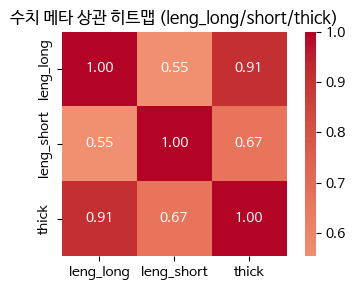

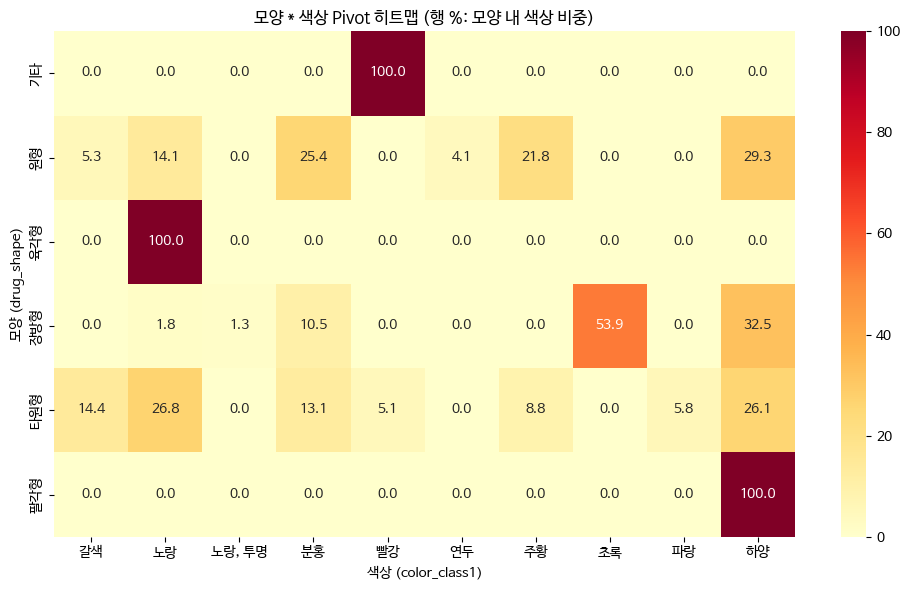

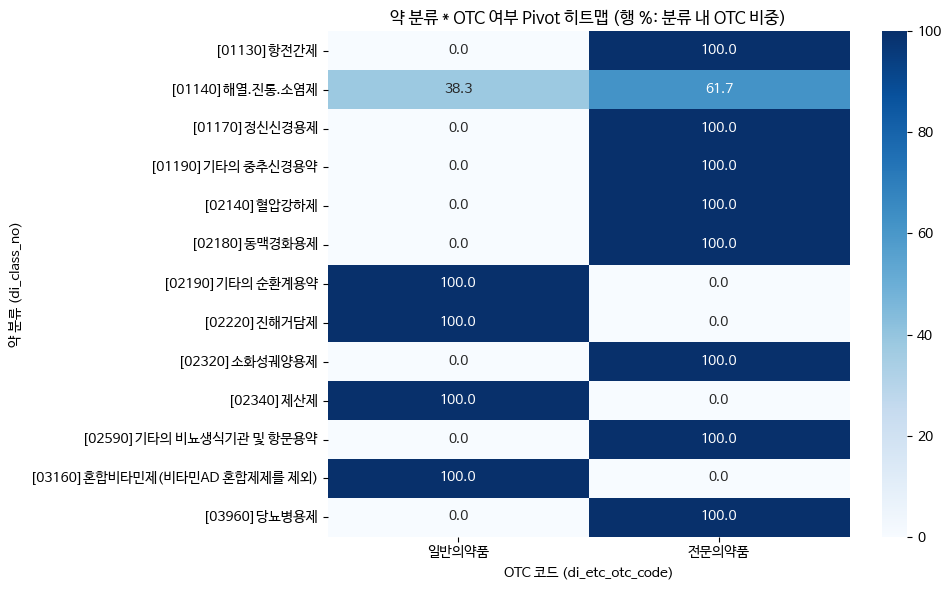

In [ ]:
# 1. 추가 라이브러리 불러오기 (이미 imports에 있음, 중복 확인)
# - seaborn (sns): 히트맵 그리기 전문.
# - plt: 그래프 표시/저장.
# - pd: crosstab/pivot_table용.
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 2. 수치 메타 상관 히트맵 (알약 크기: 길이/두께 등)
# - numeric_meta: NaN 제거 후 숫자 열 선택 (leng_long: 긴 길이, etc.).
# - corr(): 상관계수 행렬 계산 (-1~1: 음/양 관계 강도).
numeric_meta = images_df[['leng_long', 'leng_short', 'thick']].dropna()  # NaN 행 제거.
corr_matrix = numeric_meta.corr()  # 상관계수 계산 (Pearson 기본).

# 그래프 그리기
plt.figure(figsize=(4, 3))  # 그래프 크기 설정 (가로 4인치, 세로 3인치).
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True)  # 히트맵: annot=숫자 표시, cmap=색상 맵.
plt.title('수치 메타 상관 히트맵 (leng_long/short/thick)')  # 제목.
plt.tight_layout()  # 레이아웃 자동 조정.
plt.savefig('../data/processed/numeric_meta_heatmap.png', dpi=150, bbox_inches='tight')  # PNG 저장 (고해상도).
plt.show()  # 화면에 표시.

# 3. Pivot 히트맵 1: drug_shape x color_class1 (모양-색상 조합)
# - pd.crosstab(): 교차표 생성 (행: 모양, 열: 색상, 값: 빈도).
# - normalize='index': 행별 %로 정규화 (전체 100% 기준).
shape_color_pivot = pd.crosstab(images_df['drug_shape'], images_df['color_class1'], normalize='index') * 100

plt.figure(figsize=(10, 6))
sns.heatmap(shape_color_pivot, annot=True, cmap='YlOrRd', fmt='.1f')  # YlOrRd: 노랑-빨강 그라데이션.
plt.title('모양 * 색상 Pivot 히트맵 (행 %: 모양 내 색상 비중)')
plt.xlabel('색상 (color_class1)')
plt.ylabel('모양 (drug_shape)')
plt.tight_layout()
plt.savefig('../data/processed/shape_color_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# 4. Pivot 히트맵 2: di_class_no x di_etc_otc_code (약 분류-OTC 여부)
# - crosstab: 교차표, % 정규화.
otc_pivot = pd.crosstab(images_df['di_class_no'], images_df['di_etc_otc_code'], normalize='index') * 100

plt.figure(figsize=(10, 6))
sns.heatmap(otc_pivot, annot=True, cmap='Blues', fmt='.1f')  # Blues: 파랑 그라데이션.
plt.title('약 분류 * OTC 여부 Pivot 히트맵 (행 %: 분류 내 OTC 비중)')
plt.xlabel('OTC 코드 (di_etc_otc_code)')
plt.ylabel('약 분류 (di_class_no)')
plt.tight_layout()
plt.savefig('../data/processed/class_otc_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# 히트맵을 통해 '모양이 원형인 알약은 흰색이 많다' 같은 인사이트를 얻음. 모델 설계에 유용!